In [ ]:
import os

import torch

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim

import pandas as pd

from torchvision.datasets import CIFAR10


%matplotlib inline

# DataLoader Functions and Classes

In [ ]:
def data_loader(path, path2=None):
    metadata = pd.read_csv(path)
    image_paths = metadata.Image.values
     
    if path2 is not None:
        lbp = pd.read_csv(path2)
    
        features = np.concatenate([
            column_extractor(lbp.Lbp.tolist()),
            column_extractor(metadata.Color.tolist()),
            column_extractor(metadata.Glcm.tolist()),
            column_extractor(metadata.Gccrop.tolist()),
            column_extractor(metadata.Lbp.tolist()),
            ], axis=1)
    else:
        features = np.concatenate([
        column_extractor(metadata.Color.tolist()),
        column_extractor(metadata.Glcm.tolist()),
        column_extractor(metadata.Gccrop.tolist()),
        column_extractor(metadata.Lbp.tolist()),
        ], axis=1)
        
    columns = [f'F_{i:0>3}' for i in range(len(features))]
    features = pd.DataFrame(features, columns)
    feat2drop = features.loc[:, features.var(axis=0) == 0].columns
    features.drop(feat2drop, axis=1, inplace=True)
    return (image_paths, features)

def column_extractor(feature_list):
    feature_list = [
        list(map(float, item.strip('[]').split(',')))
        for item in feature_list
    ]
    return np.array(feature_list)

In [ ]:
class LentilDataset(Dataset): 
    def __init__(self, features): 
        super(LentilDataset, self).__init__()
        self.features = features
        
    def __len__(self): 
        return len(self.features)
    
    def __getitem__(self, item): 
        feature = self.features[item]
        
        feature = (feature - feature.mean()) / (feature.max() - feature.min())
        feature = torch.tensor(feature).float()
            
        return item, feature

# Data Loader.  

In [ ]:
paths, df = data_loader('ImageProcessingPipeline/data/processed/real_features.csv')
features = df.to_numpy()

In [ ]:
train_features, valid_features= np.split(features, [int(.8*len(df))])

In [ ]:
train_dataset = LentilDataset(train_features)
valid_dataset = LentilDataset(valid_features)
train_dataset.features.shape

(1272, 1835)

In [ ]:
# Define dataloaders. 
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0
)
valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0
)



'\ntest_loader = DataLoader(\n    test_dataset,\n    batch_size=BATCH_SIZE, \n    shuffle=False,\n    num_workers=0\n)\n'

In [ ]:
for data in train_loader:
    items, features = data
    print(features.shape)

torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([32, 1835])
torch.Size([24, 1835])


# Model Definition

In [95]:
class MLPModel(nn.Module):
    def __init__(self, feature_size):
        super().__init__()
        self.feature_size = feature_size
        
        self.encoder = nn.Sequential(
            nn.Linear(feature_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32)
        )
        
        self.decoder =nn.Sequential(
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, feature_size)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Set device to ', device)
model = MLPModel(feature_size=1835)
model = model.to(device)

Set device to  cpu


In [97]:
print(model)

MLPModel(
  (encoder): Sequential(
    (0): Linear(in_features=1835, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, m

# Optimizer and Criterion Definition. 

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [ ]:
MAXEPOCH = 50

train_loss_tracking = []
vlaid_loss_tracking = []

for epoch in range(MAXEPOCH):
    # Change the development mode to the training mode. 
    model.train()
    running_loss = 0.0
    
    running_steps = 0
    for i, data in enumerate(train_loader, 0):
        _, features = data
        features=features.to(device)

        optimizer.zero_grad()

        outputs = model(features)
        

        loss = criterion(outputs, features.clone())
        loss.backward()
        optimizer.step()


        running_loss += loss.item()

        running_steps += 1
    train_loss = running_loss / running_steps
    train_loss_tracking.append(train_loss)

    print(f'Train --> Epoch: {epoch}, Loss: {train_loss}.')

    # Evaluate the model for this epoch. 
    # Change the development mode to the evaluating mode. 
    model.eval()
    with torch.no_grad():
        running_loss = 0.0

        running_steps = 0
        for i, data in enumerate(valid_loader, 0):
            _, features = data
            features=features.to(device)

            outputs = model(features)
            loss = criterion(outputs, features)

           

            running_loss += loss.cpu().item()
  
            running_steps += 1
        valid_loss = running_loss / running_steps
        vlaid_loss_tracking.append(valid_loss)

        print(f'Valid --> Epoch: {epoch}, Loss: {valid_loss}.')
        print('-' * 50)
        
print('Finished.')

Train --> Epoch: 0, Loss: 0.09217337006703019.
Valid --> Epoch: 0, Loss: 0.01986293252557516.
--------------------------------------------------
Train --> Epoch: 1, Loss: 0.02797339386306703.
Valid --> Epoch: 1, Loss: 0.013309492263942957.
--------------------------------------------------
Train --> Epoch: 2, Loss: 0.012136029719840735.
Valid --> Epoch: 2, Loss: 0.010616773553192616.
--------------------------------------------------
Train --> Epoch: 3, Loss: 0.00792184517486021.
Valid --> Epoch: 3, Loss: 0.0076739702373743056.
--------------------------------------------------
Train --> Epoch: 4, Loss: 0.005250345729291439.
Valid --> Epoch: 4, Loss: 0.0048788778716698285.
--------------------------------------------------
Train --> Epoch: 5, Loss: 0.004063761315774172.
Valid --> Epoch: 5, Loss: 0.0034601550316438077.
--------------------------------------------------
Train --> Epoch: 6, Loss: 0.0031480810430366546.
Valid --> Epoch: 6, Loss: 0.0027961299289017915.
---------------------

# Visualize the Loss Values along different epochs. 

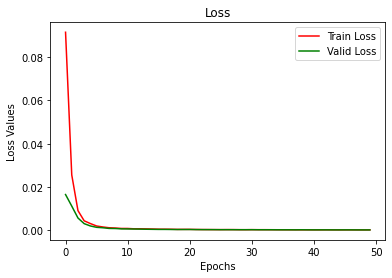

In [ ]:
plt.plot(range(len(train_loss_tracking)), train_loss_tracking, 'r-', label='Train Loss')
plt.plot(range(len(vlaid_loss_tracking)), vlaid_loss_tracking, 'g-', label='Valid Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Values')
plt.legend()
plt.show()

# Save, load, and test the model. 

In [ ]:
# change path to where you want to save model to
PATH = 'Experiments/MLP_Model1/MLPModel1_1024_32.pth'
torch.save(model.state_dict(), PATH)

In [96]:
# Load the best saved model. 
checkpoint = torch.load('Experiments/MLP_Model1/MLPModel1_1024_32.pth')
# Define the base model.
model = MLPModel(feature_size=1835)
# Load the weights. 
model.load_state_dict(checkpoint)
model = model.to(device)
model = model.eval()

In [ ]:
# encode the features
features = df.to_numpy()

feature_dataset = LentilDataset(features)
feature_loader = DataLoader(
    feature_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0
)

output_features = []
output_items = []
with torch.no_grad():
    for i, data in enumerate(feature_loader):
        items, features = data
        features = features.to(device)
        output = model.encoder(features)
        output_features.extend(output.cpu().numpy().tolist())
        output_items.extend(items.numpy().tolist())

paths = np.array(paths)
encoded_features = pd.DataFrame(output_features)
encoded_features.head()

path_df = pd.DataFrame(paths[output_items], columns=['Image'])

encoded_features = pd.concat([path_df, encoded_features], axis=1)
encoded_features.head()

,Image,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,data/processed/real_regions/0000_16401081_1.png,-0.239764,-1.019379,-0.346687,-1.134223,0.953623,-0.489345,-0.500263,-0.908257,0.135639,...,-0.518105,-0.686634,-0.482850,-0.560879,-0.277670,-0.278536,-0.320225,0.746123,-0.379762,-0.373733
1,data/processed/real_regions/0001_16401081_10.png,-0.465878,-0.973409,-0.228608,-1.277515,0.958979,-0.448639,-0.619784,-1.081189,0.261915,...,-0.413013,-0.635301,-0.547232,-0.643058,-0.317868,-0.257788,-0.287477,0.691416,-0.361773,-0.383534
2,data/processed/real_regions/0002_16401081_11.png,-0.452348,-0.635310,-0.420549,-0.897135,1.046878,-0.420234,-0.497287,-0.635895,0.231592,...,-0.317345,-0.202304,-0.195658,-1.002852,-0.383824,-0.279611,-0.427565,0.749669,-0.290503,-0.356184
3,data/processed/real_regions/0003_16401081_12.png,-0.437938,-1.007361,-0.303397,-1.376005,1.003717,-0.523574,-0.653041,-1.114258,0.238400,...,-0.500840,-0.653560,-0.514833,-0.583210,-0.198052,-0.295081,-0.228383,0.726096,-0.345267,-0.428249
4,data/processed/real_regions/0004_16401081_14.png,-0.369338,-0.802248,-0.212950,-1.032188,0.803689,-0.318665,-0.328542,-1.230685,0.144174,...,-0.590844,-0.262846,-0.531957,-0.523357,-0.299751,-0.522190,-0.378554,0.634659,-0.087520,-0.117878


In [ ]:
# change path to where you want encoded features saved to
encoded_features.to_csv('Experiments/MLP_Model1//encoded_features.csv', index=False)

# Encode New Lentil Features (a new dataset not used above)

In [107]:
# Load the best saved model. 
checkpoint = torch.load('Experiments/MLP_Model1//DeepModel1_1024_32.pth')
# Define the base model.
model = MLPModel(feature_size=1835)
# Load the weights. 
model.load_state_dict(checkpoint)
model = model.to(device)
model = model.eval()

In [108]:
# load the data
glcm_df = pd.read_csv('metadata/new/glcm.csv')
gcc_df = pd.read_csv('metadata/new/gccrop.csv')
lbp_df= pd.read_csv('metadata/new/lbp.csv')
colours_df = pd.read_csv('metadata/new/colours.csv')

features_df = glcm_df.merge(gcc_df, on='Path')
features_df = features_df.merge(lbp_df, on="Path")
features_df = features_df.merge(colours_df, on="Path")

paths = features_df["Path"]
features_df = features_df.iloc[:, 1:]
features_df.head()

/var/folders/c8/9q_gdr094zx7cdf4lp5gc5z000glxp/T/ipykernel_31881/2007393249.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Features0010_x', 'Features0018_x', 'Features0009_x', 'Features0016_x', 'Features0001_x', 'Features0007_x', 'Features0008_x', 'Features0005_x', 'Features0015_x', 'Features0002_x', 'Features0000_x', 'Features0017_x', 'Features0004_x', 'Features0006_x', 'Features0013_x', 'Features0019_x', 'Features0014_x', 'Features0003_x', 'Features0012_x', 'Features0011_x'} in the result is deprecated and will raise a MergeError in a future version.
  features_df = features_df.merge(colours_df, on="Path")


,Features0000_x,Features0001_x,Features0002_x,Features0003_x,Features0004_x,Features0005_x,Features0006_x,Features0007_x,Features0008_x,Features0009_x,...,Features0245_y,Features0246_y,Features0247_y,Features0248_y,Features0249_y,Features0250_y,Features0251_y,Features0252_y,Features0253_y,Features0254_y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.519531,0.519531,0.519531,0.519531,0.519531,0.519531,0.640625,0.640625,0.640625,0.640625,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.042969,0.042969,0.042969,0.042969,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [109]:
# encode the features
features = features_df.to_numpy()

feature_dataset = LentilDataset(features)
feature_loader = DataLoader(
    feature_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0
)

output_features = []
output_items = []
with torch.no_grad():
    for i, data in enumerate(feature_loader):
        items, features = data
        features = features.to(device)
        output = model.encoder(features)
        output_features.extend(output.cpu().numpy().tolist())
        output_items.extend(items.numpy().tolist())

paths = np.array(paths)
encoded_features = pd.DataFrame(output_features)
encoded_features.head()

path_df = pd.DataFrame(paths[output_items], columns=['Image'])

encoded_features = pd.concat([path_df, encoded_features], axis=1)
encoded_features.head()

,Image,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,../../../Desktop/New_Lentils/brown-marbled-705...,-0.515018,-1.109583,-1.503038,2.639349,0.557113,2.706753,1.673643,0.612868,1.201330,...,-1.692108,-2.533953,2.315301,-0.396628,-1.022466,-1.316653,0.726105,4.032653,-1.241618,-0.554506
1,../../../Desktop/New_Lentils/brown-marbled-705...,-0.519995,-1.118364,-1.432239,2.636273,0.586249,2.748581,1.675357,0.627036,1.225140,...,-1.677867,-2.492073,2.360404,-0.360366,-0.971100,-1.279968,0.697061,4.044016,-1.182493,-0.541687
2,../../../Desktop/New_Lentils/brown-marbled-705...,-0.516553,-1.107391,-1.481799,2.649528,0.585725,2.735550,1.663095,0.633206,1.225655,...,-1.676208,-2.519499,2.338145,-0.379308,-0.995481,-1.305787,0.708677,4.048633,-1.210562,-0.543196
3,../../../Desktop/New_Lentils/brown-marbled-705...,-0.533245,-1.112543,-1.465940,2.637363,0.565678,2.722894,1.675655,0.621697,1.207232,...,-1.690161,-2.507153,2.339423,-0.376351,-0.997499,-1.299004,0.728099,4.029946,-1.210553,-0.539367
4,../../../Desktop/New_Lentils/brown-marbled-705...,-0.495666,-1.102903,-1.572198,2.640399,0.514628,2.711427,1.703423,0.597742,1.203958,...,-1.712073,-2.588059,2.300238,-0.431820,-1.057143,-1.365184,0.739574,4.029470,-1.315311,-0.565174


In [113]:
# save encoded features
encoded_features.to_csv('Experiments/MLP_Model1//new_encoded_features.csv', index=False)